# Global Societal Endangerment Index (GSEI)

Development notebook for step 4: Multivariate Analysis

Remaining indicators after this step: 8 + 6 + 6 + 7 + 7 = 34

In [29]:
import pandas as pd
import numpy as np
import categories as my_cat
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import json

In [30]:
# load data
df = pd.read_csv("data/processing/imputed_all_data.csv")
countries = pd.read_csv("data/processing/selected_countries.csv")

df.head(10)

,Temp Change max 2012-2022,Disaster Affected Population 2020-2025,Disaster Damage US$T 2020-2025,"Unsafe water, sanitation (YLL)",Air pollution (YLL),Safe Drinking Water (%),Food Insecurity (%),Undernourishment (%),Renewable Freshwater per Capita (m3),Corruption Control,...,Renewable Energy Consumption (%),Internet Users (%),Secure Internet Servers,Future Conflict Risk,Current Conflict Intensity,COVID-19 Expenditure per Capita (US$),Prevalence HIV/AIDS,Prevalence TB/Respiratory,Prevalence Malaria/Tropical,Prevalence Other Infectious
0,2.012,1.301606e+07,0.000000e+00,1422.29,4283.98,30.034098,80.900000,30.400000,1178.737859,-1.154932,...,20.0,59.388438,43.758544,0.922130,335.00,2.000000,13.08,20436.28,22050.99,1619.54
1,1.752,4.544311e+06,0.000000e+00,1710.48,2429.79,44.159050,79.200000,23.200000,4285.826520,-0.609920,...,52.9,39.293500,40.217790,0.346535,0.00,2.000000,1461.24,33231.90,38007.20,2256.36
2,2.028,8.400000e+01,0.000000e+00,26.79,1660.57,70.736068,32.200000,4.500000,9567.281462,-0.332219,...,41.9,82.613700,1220.332909,0.007443,0.00,80.500000,1.07,22568.22,903.34,1063.17
3,3.243,1.149573e+05,1.371492e+10,2.19,239.38,90.640001,9.616279,2.609091,4027.359502,1.251356,...,18.4,94.485500,14618.581181,0.036854,27.84,281.206897,53.38,12313.50,234.83,385.35
4,1.699,3.460000e+02,0.000000e+00,9.79,618.65,95.657279,10.000000,2.700000,15.665548,1.073664,...,1.0,100.000000,2119.661179,0.009810,0.00,379.000000,31.04,31692.01,4985.35,1077.42
5,1.123,9.794250e+05,9.384690e+08,30.34,660.86,73.703829,36.100000,3.200000,6444.169076,-0.360884,...,9.2,88.375400,5451.201504,0.027757,0.00,80.500000,338.77,21909.67,8783.15,732.95
6,2.772,2.126500e+04,0.000000e+00,26.70,2601.29,82.411724,7.800000,2.500000,2315.430578,0.058400,...,9.1,77.027700,1166.538500,0.251417,20.00,56.000000,47.10,24060.53,2892.90,1216.81
7,1.131,5.254044e+05,7.836475e+08,69.14,893.41,73.703829,33.000000,5.556757,563.081354,0.326793,...,0.9,91.412300,803.720691,0.000000,0.00,80.500000,268.96,22017.50,13086.34,1346.62
8,1.499,2.905580e+05,1.713535e+10,3.79,255.71,95.657279,12.900000,2.500000,19154.841667,1.781205,...,12.3,94.876200,47567.630951,0.006948,0.00,707.000000,72.37,13385.26,263.26,427.80
9,2.524,2.220000e+03,0.000000e+00,4.41,489.99,98.896323,4.900000,2.500000,6141.273635,1.133653,...,36.0,93.614100,42281.001441,0.006267,0.00,681.000000,88.43,11308.65,323.41,423.14


### Collinearity Analysis

Check for multicollinearity between the independent variables.

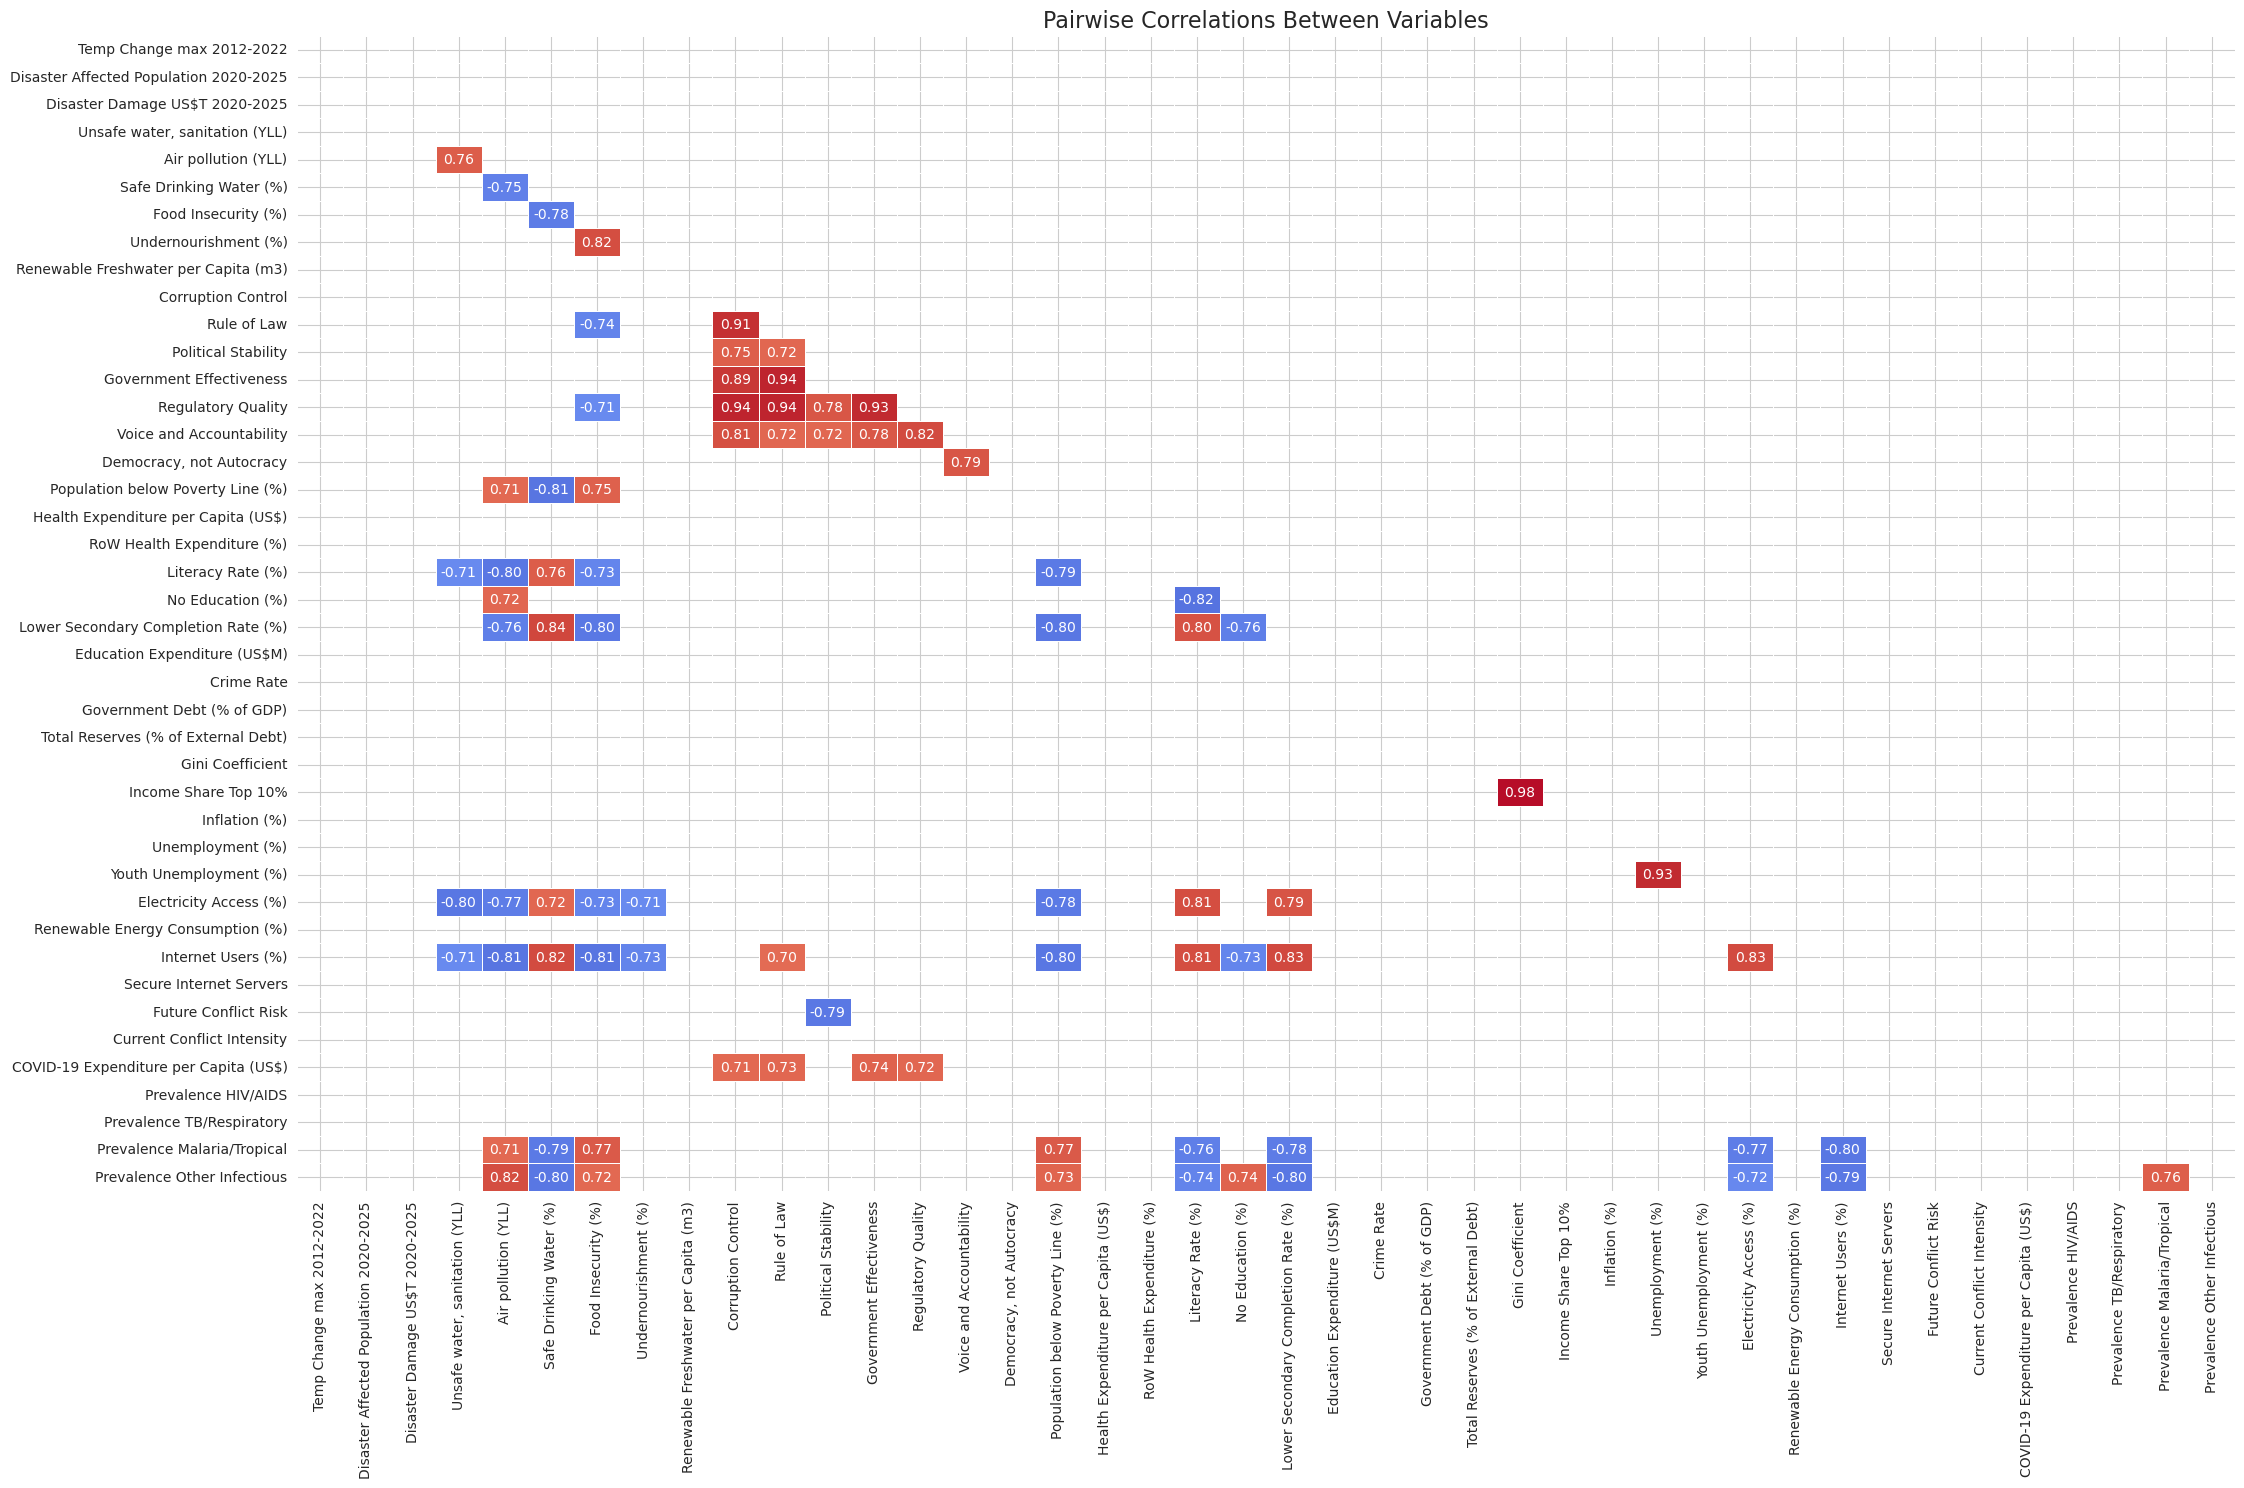

In [31]:
def corr_matrix(df):
    return df.corr(method='pearson')

# Correlation Matrix Heatmap
def corr_heatmap(df, cut_triu=True, mask_below=0.7, figsize=(25, 15)):
    correlation_matrix = corr_matrix(df)
    
    # create heatmap with mask
    plt.figure(figsize=figsize)
    plt.title("Pairwise Correlations Between Variables", fontsize=16)
    
    mask = np.abs(correlation_matrix) < mask_below
    if cut_triu:
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool)) | mask
    else:
        mask = (np.zeros_like(correlation_matrix, dtype=bool)) | mask
    
    sns.heatmap(correlation_matrix, vmin=-1, vmax=1, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, mask=mask, cbar=False)

corr_heatmap(df, cut_triu=True)

In [32]:
def correlation_matrix_to_table(corr_matrix, threshold=0.7, take_abs=True):
    """
    Converts a correlation matrix to a table of variable pairs and their correlations,
    filtering for correlations with absolute value greater than or equal to a threshold.
    """
    correlations = []
    variables = corr_matrix.columns
    
    for i in range(len(variables)):
        for j in range(i + 1, len(variables)):  # Avoid self-correlation and duplicates
            var1 = variables[i]
            var2 = variables[j]
            correlation = corr_matrix.loc[var1, var2]

            if abs(correlation) >= threshold:
                correlations.append({'var1': var1, 'var2': var2, 'correlation': abs(correlation) if take_abs else correlation})

    return pd.DataFrame(correlations).sort_values(by='correlation', ascending=False)


# show table of pairs with correlation
correlation_matrix_to_table(corr_matrix(df), threshold=0.8)

,var1,var2,correlation
22,Gini Coefficient,Income Share Top 10%,0.980451
14,Rule of Law,Regulatory Quality,0.941035
11,Corruption Control,Regulatory Quality,0.940487
13,Rule of Law,Government Effectiveness,0.940321
15,Government Effectiveness,Regulatory Quality,0.928910
23,Unemployment (%),Youth Unemployment (%),0.928807
9,Corruption Control,Rule of Law,0.906644
10,Corruption Control,Government Effectiveness,0.886279
4,Safe Drinking Water (%),Lower Secondary Completion Rate (%),0.842355
20,Lower Secondary Completion Rate (%),Internet Users (%),0.828963


## Measures
- Remove Income Share Top 10% (-> GINI coefficient)
- Remove Unemployment (-> Youth Unemployment)
- Remove Internet Users (-> Electricity Access)
- Remove Lower secondary completion rate (-> No education)
- Remove Literacy Rate (-> No education)
- Remove Food Insecurity (-> Undernourishment)
- PCA for all political indicators, they are all highly correlated
- PCA for Unsafe Water & Sanitation, Air pollution, Safe drinking water
- PCA for Infectious Diseases, to try and reduce correlation with indicators from other categories

The heatmap without variables for which measures were taken looks quite good now.

22


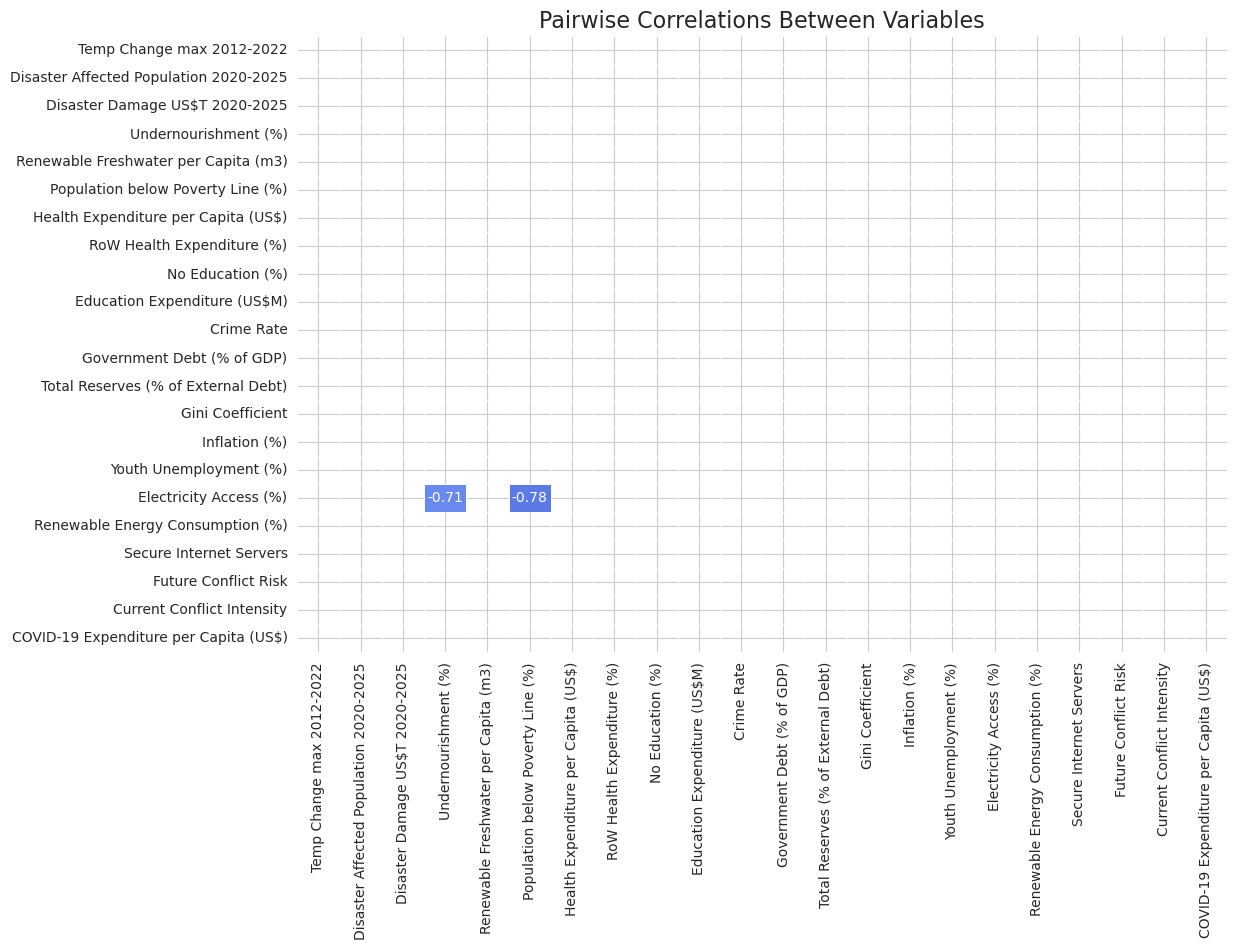

In [33]:
dropped_columns = ['Income Share Top 10%', 'Unemployment (%)', 'Internet Users (%)', 'Lower Secondary Completion Rate (%)', 'Literacy Rate (%)', 'Food Insecurity (%)']
df_trimmed = df.drop(columns=dropped_columns + my_cat.load()['pol'] + ['Unsafe water, sanitation (YLL)', 'Air pollution (YLL)', 'Safe Drinking Water (%)', 'Prevalence HIV/AIDS', 'Prevalence TB/Respiratory', 'Prevalence Malaria/Tropical', 'Prevalence Other Infectious'])

print(len(df_trimmed.columns))

corr_heatmap(df_trimmed, cut_triu=True, mask_below=0.7, figsize=(12, 8))

- Electricity Access still has high correlations, and with 0.78, population below poverty line can be a feasible proxy for it. 

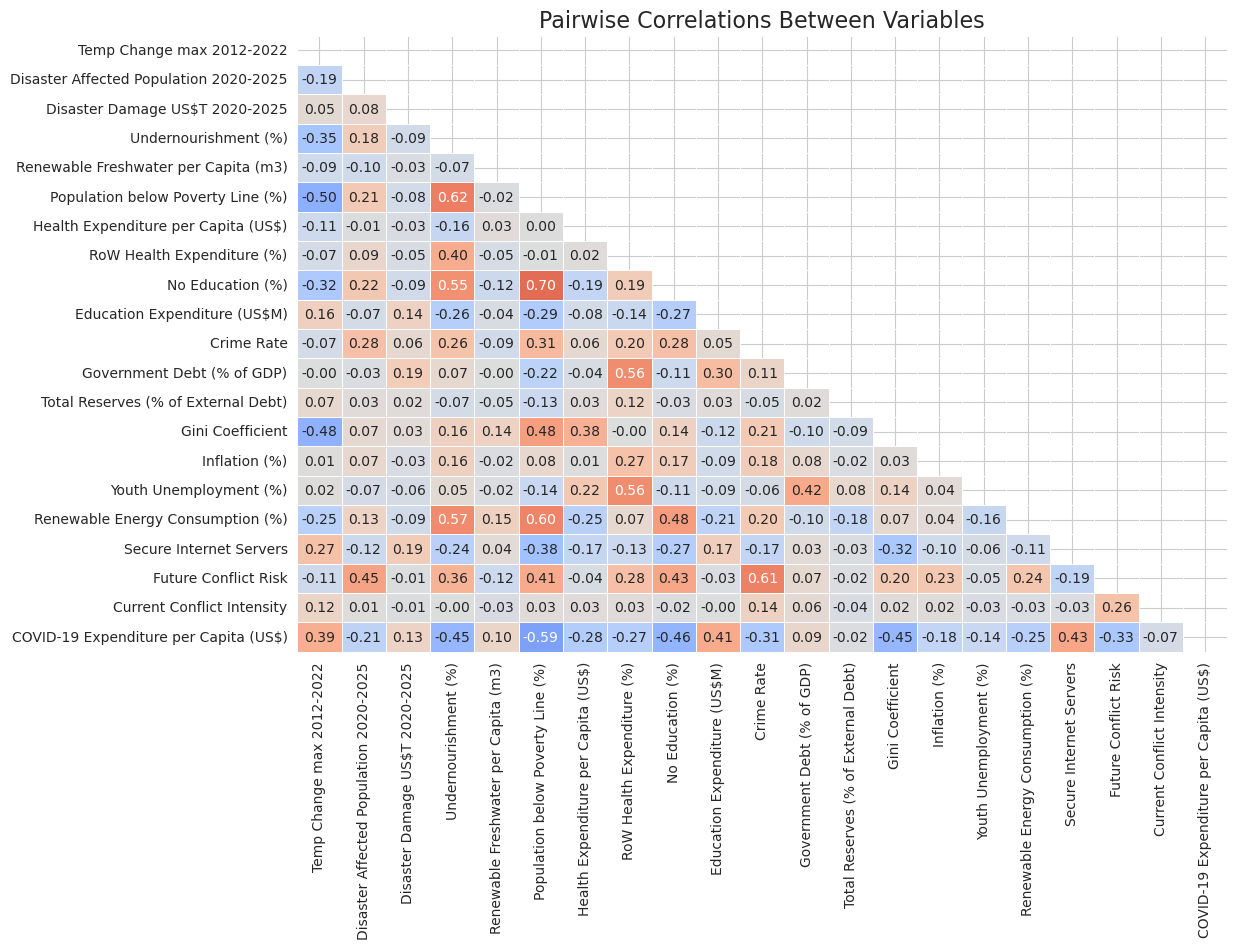

In [34]:
df_trimmed2 = df_trimmed.drop(columns='Electricity Access (%)')
dropped_columns.append('Electricity Access (%)')

corr_heatmap(df_trimmed2, cut_triu=True, mask_below=0, figsize=(12, 8))

## PCA

Apply to the whole dataset first for investigation, then to the categories with high correlation for transformation.

In [35]:
def component_loadings(components, original_columns, figsize=(20, 15)):
    """
    Extract and visualize component loadings
    """
    loadings = pd.DataFrame(
        components.T,
        columns=[f'PC{i+1}' for i in range(len(components))],
        index=original_columns
    )

    plt.figure(figsize=figsize)
    sns.heatmap(loadings, cmap='coolwarm', center=0, annot=True, fmt='.2f', cbar=True)
    plt.title('PCA Component Loadings')
    plt.tight_layout()
    plt.show()

    return loadings

34
[0.381 0.089 0.07  0.065 0.042 0.03  0.027 0.024 0.023 0.022 0.022 0.021
 0.018 0.017 0.015 0.014 0.013 0.012 0.011 0.011 0.008 0.008 0.007 0.006
 0.006 0.005 0.004 0.004 0.004 0.003 0.003 0.003 0.002 0.002]


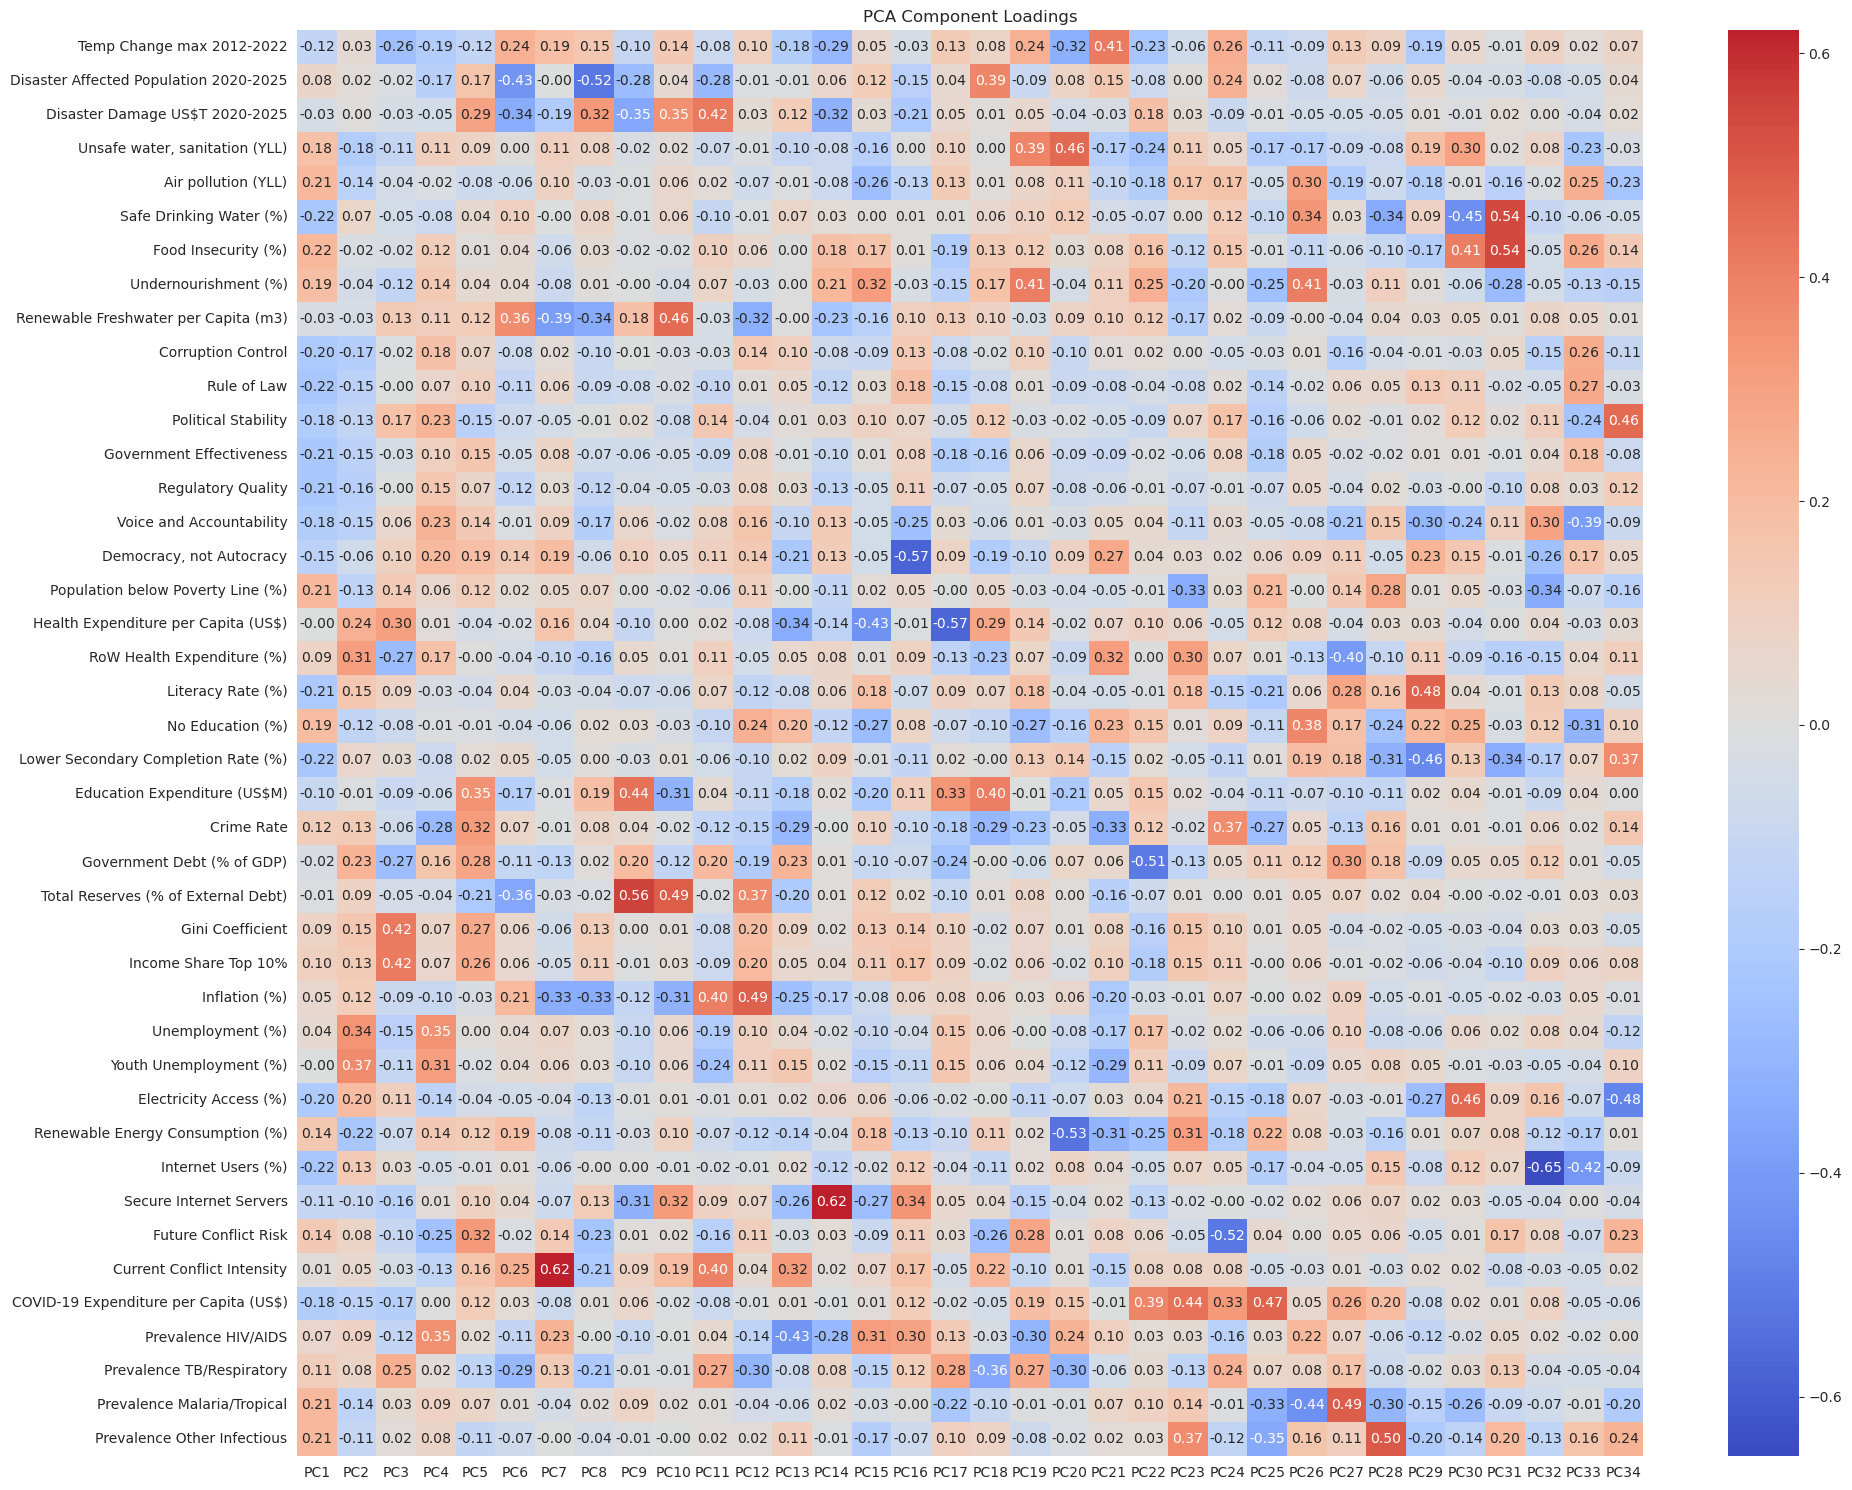

,index,PC1
0,Food Insecurity (%),0.217434
1,Population below Poverty Line (%),0.210812
2,Prevalence Other Infectious,0.210754
3,Air pollution (YLL),0.209753
4,Prevalence Malaria/Tropical,0.207731
5,No Education (%),0.193984
6,Undernourishment (%),0.188664
7,"Unsafe water, sanitation (YLL)",0.175529
8,Renewable Energy Consumption (%),0.143977
9,Future Conflict Risk,0.138507


In [36]:
# apply PCA to the whole dataset
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

pca = PCA(0.99)
df_pca = pca.fit_transform(df_scaled)

print(len(pca.components_))
print(pca.explained_variance_ratio_.round(3))

# check which indicators are most important in PC1, and match indicator names
loadings = component_loadings(pca.components_, df.columns)

loadings['PC1'].sort_values(ascending=False).head(10).reset_index()

Text(0.5, 1.0, 'Scree Plot')

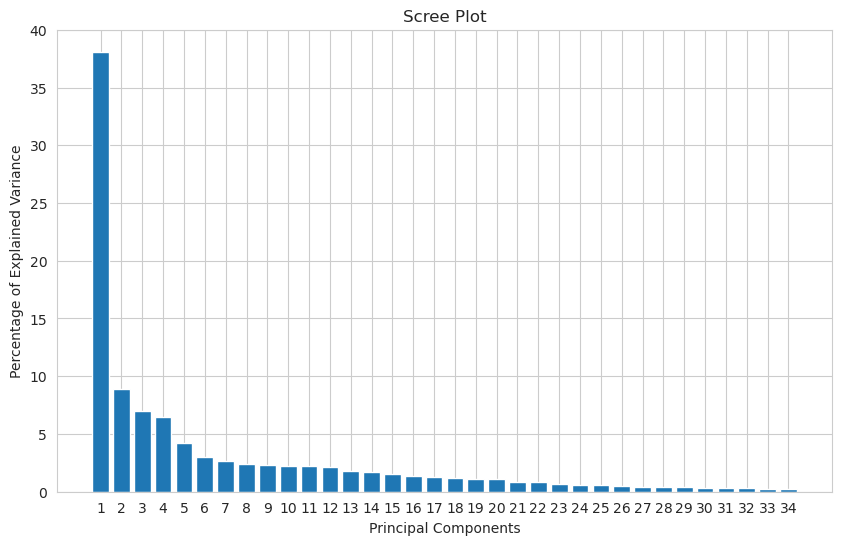

In [37]:
# scree plot
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
plt.figure(figsize=(10, 6))
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=range(1,len(per_var)+1))
plt.ylabel("Percentage of Explained Variance")
plt.xlabel("Principal Components")
plt.title('Scree Plot')

In [38]:
def get_pca(df_in, columns, out_name):
    s = StandardScaler()
    dfs = s.fit_transform(df_in[columns])
    p = PCA()
    dfp = p.fit_transform(dfs)
    dfp = pd.DataFrame(dfp, columns=[f'{out_name}_PC{i+1}' for i in range(len(p.components_))])
    return p, dfp

In [39]:
# replace the original indicators with the principal components for the cases mentioned above
col1 = my_cat.load()['pol']
col2 = ['Unsafe water, sanitation (YLL)', 'Air pollution (YLL)', 'Safe Drinking Water (%)']
col3 = ['Prevalence HIV/AIDS', 'Prevalence TB/Respiratory', 'Prevalence Malaria/Tropical', 'Prevalence Other Infectious']

pca1, df_pca1 = get_pca(df, col1, 'pol')
print(pca1.explained_variance_ratio_.cumsum())

[0.79826495 0.89758724 0.95118493 0.97366747 0.98800365 0.99456477
 1.        ]


[0.80788765 0.93428701 1.        ]


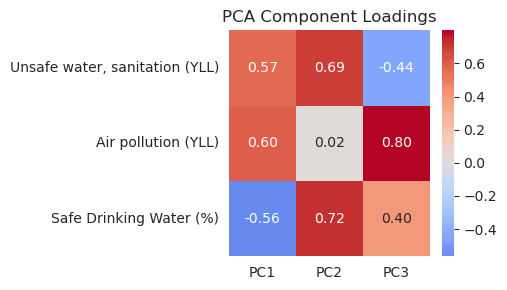

In [40]:
# keep 99%, so the first 6 components
if len(pca1.components_) > 6:
    df_pca1.drop(columns=df_pca1.columns[6:], inplace=True)
dfp1 = pd.concat([df_trimmed2, df_pca1], axis=1)

pca2, df_pca2 = get_pca(df, col2, 'water_air')

print(pca2.explained_variance_ratio_.cumsum())

# plot loadings to check if PC1 lines up regarding the relations of the variables to the resulting GSEI
l = component_loadings(pca2.components_, col2, figsize=(5, 3))

In [41]:
# PC1 loadings are good, keep all 3 components
dfp2 = pd.concat([dfp1, df_pca2], axis=1)

pca3, df_pca3 = get_pca(df, col3, 'disease')
print(pca3.explained_variance_ratio_.cumsum())

[0.53414496 0.75686309 0.93998085 1.        ]


In [42]:
# keep all 4 components
dfp3 = pd.concat([dfp2, df_pca3], axis=1)

dfp3.head(10)

,Temp Change max 2012-2022,Disaster Affected Population 2020-2025,Disaster Damage US$T 2020-2025,Undernourishment (%),Renewable Freshwater per Capita (m3),Population below Poverty Line (%),Health Expenditure per Capita (US$),RoW Health Expenditure (%),No Education (%),Education Expenditure (US$M),...,pol_PC4,pol_PC5,pol_PC6,water_air_PC1,water_air_PC2,water_air_PC3,disease_PC1,disease_PC2,disease_PC3,disease_PC4
0,2.012,1.301606e+07,0.000000e+00,30.400000,1178.737859,23.304235,81.000,8.000000,58.380000,819.557820,...,-0.157403,0.451415,-0.505144,1.653817,-0.551784,0.344034,0.090144,-0.350564,-0.636542,-0.235712
1,1.752,4.544311e+06,0.000000e+00,23.200000,4285.826520,23.304235,101.000,7.000000,23.932941,3047.738550,...,-0.231028,-0.006220,-0.390847,0.824321,-0.093015,-0.409678,1.992797,-0.404285,0.069539,-0.540231
2,2.028,8.400000e+01,0.000000e+00,4.500000,9567.281462,23.138889,414.000,0.000000,3.280000,470.235520,...,0.586811,-0.234792,0.104068,-0.578045,-0.176162,0.080052,-1.054480,-0.055411,0.311029,0.261080
3,3.243,1.149573e+05,1.371492e+10,2.609091,4027.359502,12.512500,3.192,0.076923,3.064792,96.518660,...,0.219355,-0.118686,0.035244,-1.481279,0.295753,-0.300041,-2.077185,0.333092,-0.497454,-0.189044
4,1.699,3.460000e+02,0.000000e+00,2.700000,15.665548,12.512500,2.315,0.076923,9.720000,28330.640427,...,0.846905,0.356944,-0.048044,-1.443530,0.430280,-0.053021,-0.416271,-0.269504,1.131575,0.000319
5,1.123,9.794250e+05,9.384690e+08,3.200000,6444.169076,23.800000,1.371,0.000000,0.930000,35105.550420,...,-0.065861,-0.021548,0.164119,-0.988338,-0.112748,-0.349038,-0.968767,0.076174,0.150992,-0.377158
6,2.772,2.126500e+04,0.000000e+00,2.500000,2315.430578,18.300000,675.000,0.000000,0.600000,312.116360,...,0.133574,0.267761,-0.060940,-0.476079,0.129807,0.687241,-0.784127,-0.124900,0.362462,0.285434
7,1.131,5.254044e+05,7.836475e+08,5.556757,563.081354,23.138889,1.085,0.000000,7.609643,9814.788208,...,0.055407,-0.265085,-0.123456,-0.892232,-0.092651,-0.250677,-0.358819,-0.138401,-0.149787,-0.059672
8,1.499,2.905580e+05,1.713535e+10,2.500000,19154.841667,12.512500,6.731,0.000000,0.720000,68159.446410,...,-0.129113,-0.056934,-0.283562,-1.573867,0.422967,-0.221956,-1.989580,0.308210,-0.402311,-0.163854
9,2.524,2.220000e+03,0.000000e+00,2.500000,6141.273635,12.500000,5.852,0.000000,1.290000,22413.541470,...,-0.170182,-0.206508,0.250451,-1.554774,0.507790,-0.066242,-2.093434,0.355491,-0.613993,-0.151653


In [43]:
# save new category mapping
cat = my_cat.load()

def list_drop(main_list, sublist):
    return [item for item in main_list if item not in sublist]

cat = my_cat.drop(cat, dropped_columns)
cat['pol'] = list(df_pca1.columns)
cat['env'] = list_drop(cat['env'], col2) + list(df_pca2.columns)
cat['threat'] = list_drop(cat['threat'], col3) + list(df_pca3.columns)

# save to JSON file
with open('data/processing/category_indicator_map_4.1.json', 'w') as json_file:
    json.dump(cat, json_file, indent=4)

### Save the cleaned and partially transformed dataset


In [44]:
dfp3.to_csv("data/processing/multivariate_all_data.csv", index=False)

## Clustering

Apply k-means clustering to the dataset to identify groups of countries with similar characteristics.